In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math

prng = np.random.RandomState(42)
torch.manual_seed(42)

In [2]:
from ray import tune
from ray.tune.schedulers import HyperBandScheduler

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [4]:
# Change these values if you want the training to run quicker or slower.
EPOCH_SIZE_LIMIT = 512 # maximum number of samples per epoch
NUM_EPOCH_LIMIT = 10   # maximum number of training epochs
BATCH_SIZE = 64        # batch size
TEST_SIZE = 256        # number of test samples
NUM_SAMPLE_CONFIG = 20 # number of configurations to sample

def train(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # We set this just for the example to run quickly.
        if batch_idx * len(data) > NUM_EPOCH_LIMIT:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def test(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            # We set this just for the example to run quickly.
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

In [5]:
def train_mnist(config):
    """Train the model using given configuration"""
    # Data Setup
    mnist_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307, ), (0.3081, ))])

    train_loader = DataLoader(
        datasets.MNIST("~/data", train=True, download=True, transform=mnist_transforms),
        batch_size=BATCH_SIZE,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("~/data", train=False, transform=mnist_transforms),
        batch_size=BATCH_SIZE,
        shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ConvNet()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    # R = NUM_EPOCH_LIMIT, we can train up to this number of epochs
    for i in range(NUM_EPOCH_LIMIT):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc, epoch=i+1)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [6]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * prng.rand())),
    "momentum": prng.uniform(0.1, 0.9)
}
scheduler = HyperBandScheduler(
    metric="mean_accuracy", time_attr="epoch", mode="max", max_t=NUM_EPOCH_LIMIT
)

In [7]:
R = NUM_EPOCH_LIMIT
s_max = math.floor(math.log(NUM_EPOCH_LIMIT, scheduler._eta))
eta = scheduler._eta
##Alg simulation
print("Number of brackets: ", s_max + 1)
for bi, s in enumerate(range(s_max, -1, -1)):
    n = math.ceil((s_max + 1) * (eta ** s) / (s + 1))
    r = R * (eta ** -s)
    
    print("Bracket: ", bi+1)
    print(f"\tNumber of trials: {n}")
    print(f"\tr: {r}")
    print(f"\ts: {s}")
    
    for i in range(s + 1):
        ni = math.floor(n * eta ** -i)
        ri = r * eta ** i
        print(f"\t\tEvaluate ni={ni} using ri={ri}")
            # print(f"\t\tr{i}: ", r)

Number of brackets:  3
Bracket:  1
	Number of trials: 9
	r: 1.1111111111111112
	s: 2
		Evaluate ni=9 using ri=1.1111111111111112
		Evaluate ni=3 using ri=3.3333333333333335
		Evaluate ni=1 using ri=10.0
Bracket:  2
	Number of trials: 5
	r: 3.333333333333333
	s: 1
		Evaluate ni=5 using ri=3.333333333333333
		Evaluate ni=1 using ri=10.0
Bracket:  3
	Number of trials: 3
	r: 10
	s: 0
		Evaluate ni=3 using ri=10


In [8]:
tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(num_samples=NUM_SAMPLE_CONFIG, scheduler=scheduler),
    param_space=search_space,
)
results = tuner.fit()

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = {result.log_dir: result.metrics_dataframe for result in results}


2022-11-24 17:57:48,037	INFO worker.py:1528 -- Started a local Ray instance.
2022-11-24 17:57:49,571	WARNING function_trainable.py:586 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,date,done,episodes_total,epoch,experiment_id,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mnist_d6074_00000,2022-11-24_17-57-53,False,,10,e3992f7cdb6347ff83b9f43c45ccfa5e,GFGVN20210010.local,10,0.084375,127.0.0.1,33798,1.32214,0.135634,1.32214,1669287473,0,,10,d6074_00000,0.00294876
train_mnist_d6074_00001,2022-11-24_17-57-58,False,,1,de5733c7d017403fb74167785d0828e8,GFGVN20210010.local,1,0.109375,127.0.0.1,33806,0.275921,0.275921,0.275921,1669287478,0,,1,d6074_00001,0.019649
train_mnist_d6074_00002,2022-11-24_17-58-00,True,,10,79b7558614a34222b6ab0c8c620b44b7,GFGVN20210010.local,10,0.059375,127.0.0.1,33807,1.64448,0.0956621,1.64448,1669287480,0,,10,d6074_00002,0.00388718
train_mnist_d6074_00003,2022-11-24_17-57-58,True,,3,e568ffe3bbba46d7b4d118f2dfd92db3,GFGVN20210010.local,3,0.165625,127.0.0.1,33808,0.735172,0.217305,0.735172,1669287478,0,,3,d6074_00003,0.00829291
train_mnist_d6074_00004,2022-11-24_17-57-58,False,,1,b952da21624c430db399021c47984785,GFGVN20210010.local,1,0.153125,127.0.0.1,33809,0.318479,0.318479,0.318479,1669287478,0,,1,d6074_00004,0.00369525
train_mnist_d6074_00005,2022-11-24_17-58-00,True,0,7,a57ac4b2e3d346059c1cca16ede6df40,GFGVN20210010.local,7,0.05,127.0.0.1,33808,0.924109,0.078645,1.68224,1669287480,0,0,7,d6074_00005,0.00829291
train_mnist_d6074_00006,2022-11-24_17-57-58,False,,1,10a5b6d5c789471e8a165d578aa859bb,GFGVN20210010.local,1,0.09375,127.0.0.1,33812,0.334175,0.334175,0.334175,1669287478,0,,1,d6074_00006,0.00856805
train_mnist_d6074_00007,2022-11-24_17-57-58,False,,1,a5423e4bcc5142189892a52e7de304b1,GFGVN20210010.local,1,0.11875,127.0.0.1,33813,0.312761,0.312761,0.312761,1669287478,0,,1,d6074_00007,0.00897574
train_mnist_d6074_00008,2022-11-24_17-57-53,False,,1,e3992f7cdb6347ff83b9f43c45ccfa5e,GFGVN20210010.local,1,0.11875,127.0.0.1,33798,0.099858,0.099858,0.099858,1669287473,0,,1,d6074_00008,0.00294876
train_mnist_d6074_00009,2022-11-24_17-57-59,False,0,1,e3992f7cdb6347ff83b9f43c45ccfa5e,GFGVN20210010.local,1,0.06875,127.0.0.1,33810,0.0868878,0.0868878,0.195765,1669287479,0,0,1,d6074_00009,0.00721169


(train_mnist pid=33812) 2022-11-24 17:57:59,439	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: /Users/tinphan/ray_results/train_mnist_2022-11-24_17-57-44/train_mnist_d6074_00004_4_lr=0.0275_2022-11-24_17-57-52/checkpoint_tmp87a263
(train_mnist pid=33812) 2022-11-24 17:57:59,439	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 0.7193171977996826, '_episodes_total': 0}
(train_mnist pid=33808) 2022-11-24 17:57:59,444	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: /Users/tinphan/ray_results/train_mnist_2022-11-24_17-57-44/train_mnist_d6074_00005_5_lr=0.2625_2022-11-24_17-57-52/checkpoint_tmp8ee740
(train_mnist pid=33808) 2022-11-24 17:57:59,444	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 0, '_timesteps_total': 0, '_time_total': 0.7581350803375244, '_episodes_total': 0}
2022-11-24 17:57:59,576	INFO hyperband.py:472 -- Restoring from a previous point in time. Previous=3

In [9]:
len(dfs)

20

Text(0, 0.5, 'Mean Accuracy')

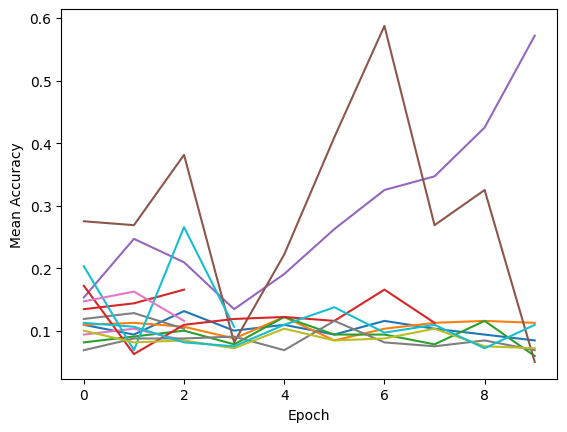

In [10]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)
ax.set_xlabel("Epoch")
ax.set_ylabel("Mean Accuracy")